<a href="https://colab.research.google.com/github/BDouchet/BMDATA/blob/main/TPAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and process data

Load STL10-dataset available at this [page](https://cs.stanford.edu/~acoates/stl10/).

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from keras.utils import plot_model

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1o6pizqpoomZNz5typ5qA5LkhN3wtAqh6'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data.zip')

with ZipFile('data.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


Read the images. I obtain two dataset : train and test. Train dataset is composed of 5000 images equally reparted into 10 classes : airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. The test dataset contains 8000 images also equally reparted in the 10 classes.

Images have a size of 96x96x3.

The following code has been adapted from this [github](https://github.com/mttk/STL10).

In [ ]:
import os.path as osp

def stl_read_labels(path_to_labels):
	with open(path_to_labels, 'rb') as f:
		labels = np.fromfile(f, dtype=np.uint8)
		return labels

def stl_read_all_images(path_to_data):
	with open(path_to_data, 'rb') as f:
		everything = np.fromfile(f, dtype=np.uint8)
		images = np.reshape(everything, (-1, 3, 96, 96))
		images = np.transpose(images, (0, 3, 2, 1))
		return images

def stl_load_stl10(folder):
	train_images = stl_read_all_images(osp.join(folder, 'train_X.bin'))
	train_labels = stl_read_labels(osp.join(folder, 'train_y.bin'))
	test_images = stl_read_all_images(osp.join(folder, 'test_X.bin'))
	test_labels = stl_read_labels(osp.join(folder, 'test_y.bin'))
	return train_images, train_labels, test_images, test_labels

X_train, Y_train, X_test, Y_test=stl_load_stl10("stl-10/")
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

extract=X_train[:5]

(5000, 96, 96, 3) (5000,) (8000, 96, 96, 3) (8000,)


Then, I process the images by applying the following steps :


*   Scale from pixel values from 0 to 1 by dividing by 255.
*   Standardize the pixel values. As a result, images will have a different brightness (mean) and contrast (standard deviation).
*   Scale them from a range between 0 and 1 : add by 3 and divide by 6. I choose 3 because according the Normal Distribution, 99.9% of the values are between -3 and 3.

The process is repeated on the test dataset with mean and std from train dataset


In [ ]:
def process(X1,X2):
    X1=np.array(X1)/255
    X2=np.array(X2)/255
    mean=np.mean(X1)
    std=np.std(X1)
    X1=(X1-mean)/std
    X2=(X2-mean)/std
    X1=(X1+3)/6
    X2=(X2+3)/6
    return np.array(X1),np.array(X2)

X_train,X_test=process(X_train,X_test)

I observe the differences between raw and processed images

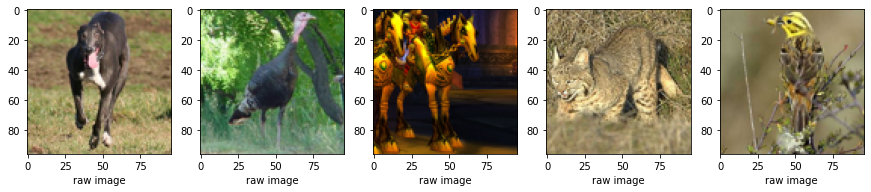

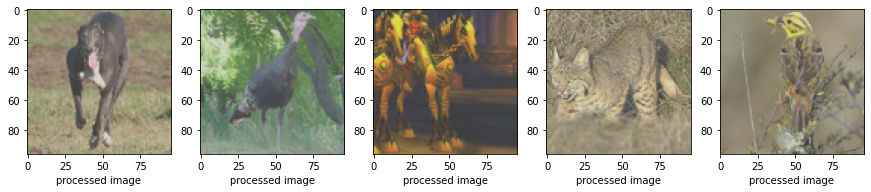

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(extract[i])
    plt.xlabel("raw image")
    plt.sca(ax)
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(X_train[i])
    plt.xlabel("processed image")
    plt.sca(ax)
plt.show()


# Create model and load weights 

I create a classical Autoencoder made of 4 weight layers (2 in the encoder and 2 in the decoder). It taks a 96x96x3 image as input and rebuild the image with a shape of 84x84x3. 

The encoder is made of two convolutionnal layers with max pooling. The decoder is composed of Transposed Convolutionnal layers and allows to up scale the image. To get more infos on the process : https://arxiv.org/abs/1603.07285.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 92, 92, 128)       9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 42, 42, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
tr_conv1 (Conv2DTranspose)   (None, 42, 42, 128)       409728    
_________________________________________________________________
tr_conv2 (Conv2DTranspose)   (None, 84, 84, 3)         9603      
Total params: 838,787
Trainable params: 838,787
Non-trainable params: 0
__________________________________________________

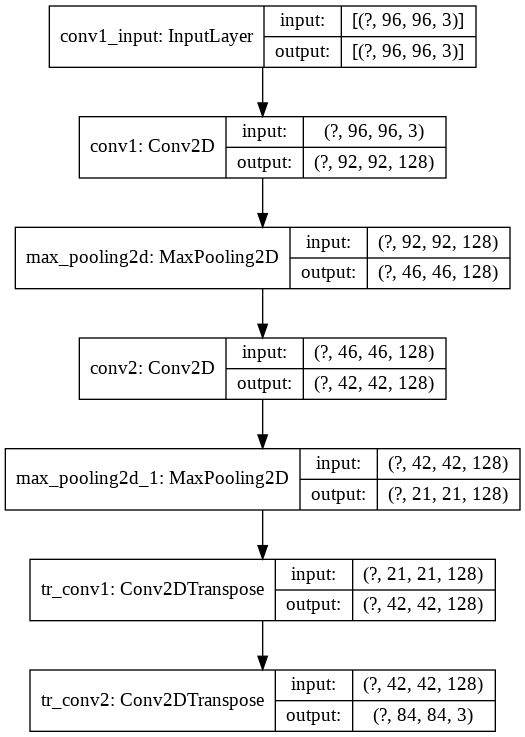

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
from tensorflow.keras.utils import plot_model

model=models.Sequential()
model.add(layers.Conv2D(128,5,input_shape=(96,96,3),padding='valid',activation='sigmoid',name='conv1'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(128,5,padding='valid',activation='sigmoid',name='conv2'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2DTranspose(128,5,strides=(2,2),padding='same',name='tr_conv1'))
model.add(layers.Conv2DTranspose(3,5,strides=(2,2),padding='same',name='tr_conv2'))
print(model.summary())
plot_model(model,show_shapes=True,show_layer_names=True)

I use weights already trained for the autoencoder. They are avalaible a this [link](https://drive.google.com/file/d/1qetY2cCWDnFNCDuvszM7t-2ufde8DCDs/view?usp=sharing). Each layer needs an array of weights and biases, each layer has a number parameters equal to : 

n = filter_size^2 * target_depth * input depth + target depth.


In [ ]:
id='1qetY2cCWDnFNCDuvszM7t-2ufde8DCDs'

dl_weight = drive.CreateFile({'id':id})
dl_weight.GetContentFile('weights.zip')

with ZipFile('weights.zip', 'r') as zip:
   zip.extractall()
   print('Done')

path="/content/model/"
name_weight=["conv1_weights","conv1_bias","conv2_weights","conv2_bias",
             "tr_conv1_weights","tr_conv1_bias","tr_conv2_weights","tr_conv2_bias"]
weights_list = model.get_weights()
weightlayers=[0,2,4,5]

for i in range(4):
    weights=np.load(path+name_weight[i*2]+".npy")
    print(weights.shape)
    bias=np.load(path+name_weight[i*2+1]+".npy")
    print(bias.shape)
    model.layers[weightlayers[i]].set_weights([weights,bias])

Done
(5, 5, 3, 128)
(128,)
(5, 5, 128, 128)
(128,)
(5, 5, 128, 128)
(128,)
(5, 5, 3, 128)
(3,)


I display input and output shape through the network to show what the network does.

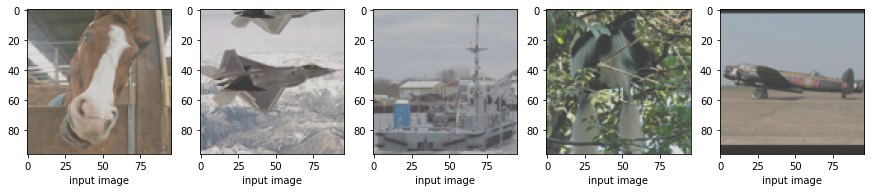

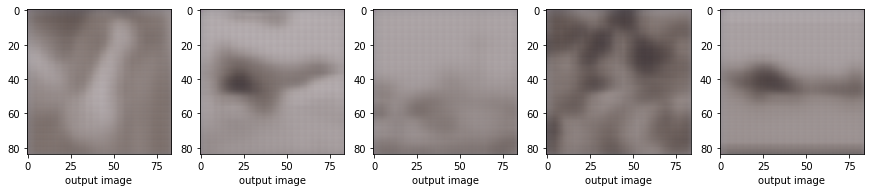

In [ ]:
pred=model.predict(X_train[10:15])
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(X_train[10+i])
    plt.xlabel("input image")
    plt.sca(ax)
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(pred[i])
    plt.xlabel("output image")
    plt.sca(ax)
plt.show()

I only keep the encoder part (two convolutionnal layers) and I calculate the associated features of input images. Those features have a size of 21x21x128.

From Train Dataset



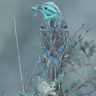

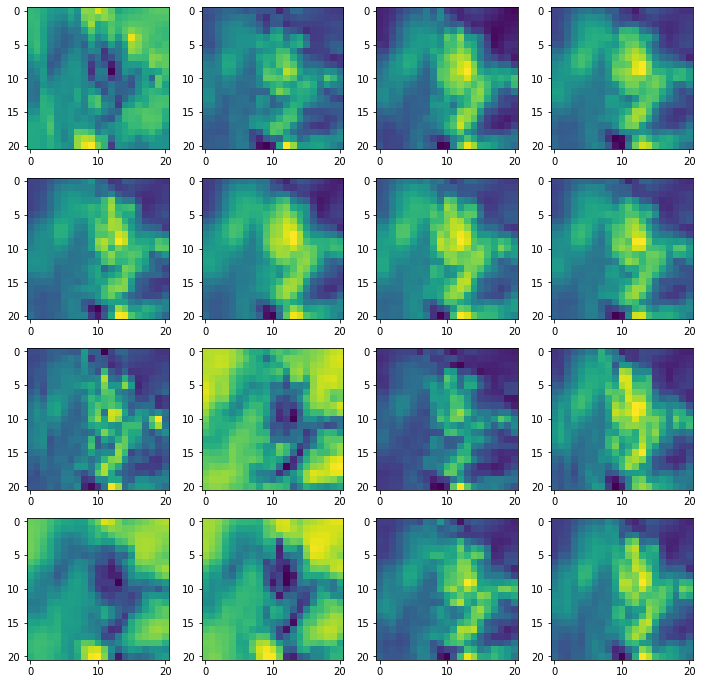

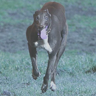

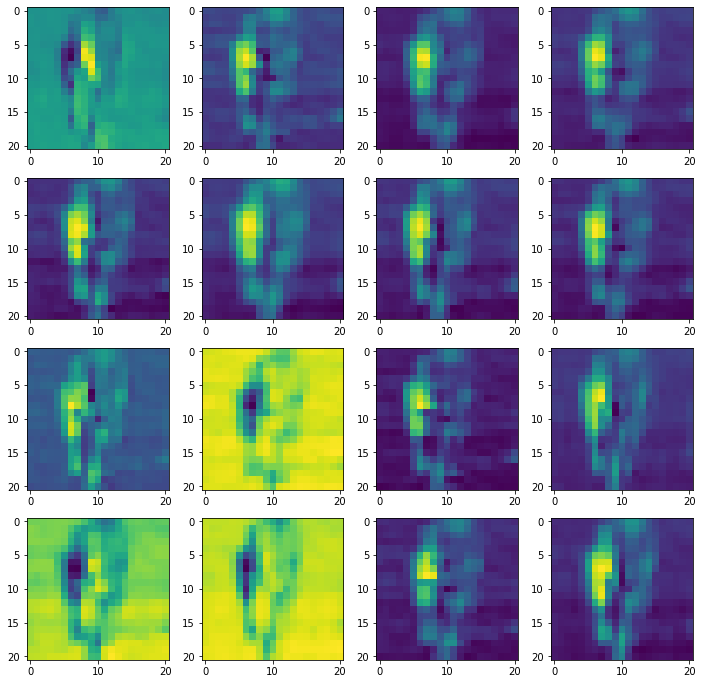


From Test Dataset



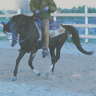

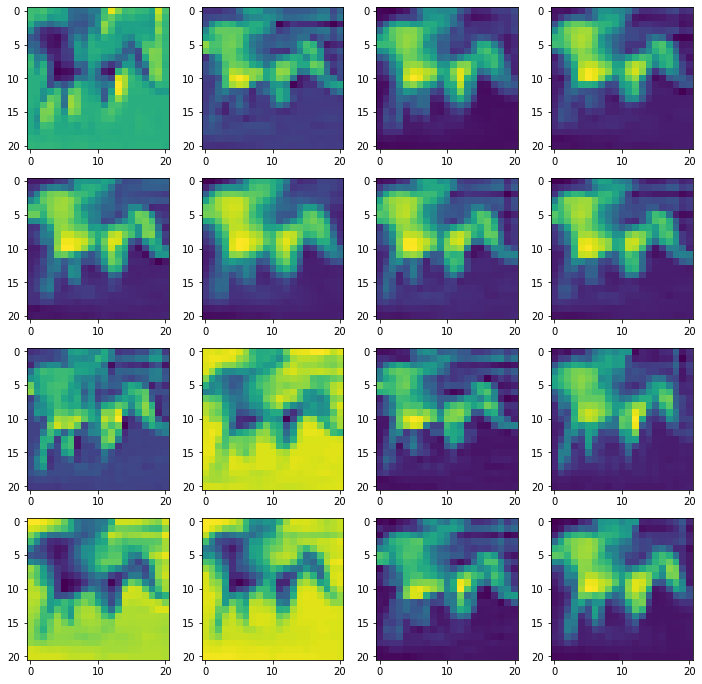

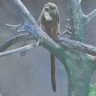

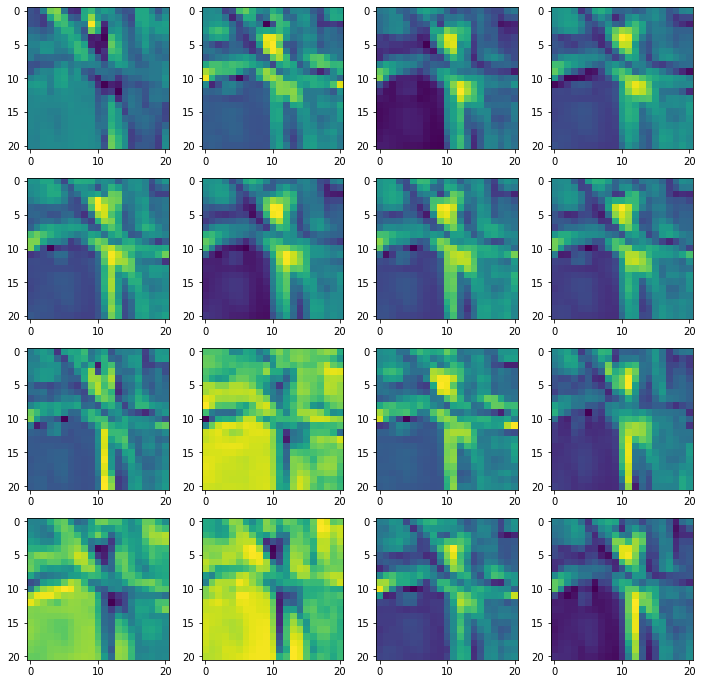

In [ ]:
encoder=models.Sequential()
for i in range(4):
    encoder.add(model.layers[i])

n=2
pred_train=encoder.predict(X_train[:n])
pred_test=encoder.predict(X_test[:n])
print("From Train Dataset")
print("")
for i in range(n):
    cv2_imshow(X_train[i]*255)
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
    for j, ax in enumerate(axs.flatten()):
        plt.imshow(pred_train[i,:,:,j]*255)
        plt.sca(ax)
    plt.show()
    print("")

print("From Test Dataset")
print("")

for i in range(n):
    cv2_imshow(X_test[i]*255)
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
    for j, ax in enumerate(axs.flatten()):
        plt.imshow(pred_test[i,:,:,j]*255)
        plt.sca(ax)
    plt.show()
    print("")


# Feature Process for the classifier

After the calculation of the feature trhough the encoder, I apply sumpooling to the features. I divide each feature map in 4 distinct region and sum all the values; the process is repeated for all the feature maps and the values are concatenated. It results a vector of size (1, 4xnumber_feature_maps) = (1,512).  

In [ ]:
XE_train,XE_test=encoder.predict(X_train),encoder.predict(X_test)
print(XE_train.shape,XE_test.shape)

def sumpooling(X):
    Y=[]
    for i in range(128):
        Y.append(np.sum(X[:10,:10,i]))
        Y.append(np.sum(X[:10,10:,i]))
        Y.append(np.sum(X[10:,:10,i]))
        Y.append(np.sum(X[10:,10:,i]))
    return Y

def calculate_sum(X):
    out=[]
    for i in X:
        out.append(sumpooling(i))
    return np.array(out)
    
XE_train,XE_test=calculate_sum(XE_train),calculate_sum(XE_test)
print(XE_train.shape,XE_test.shape)


(5000, 21, 21, 128) (8000, 21, 21, 128)
(5000, 512) (8000, 512)


# Logistic Regression

After obtaining our feature vector, I train a classifier (with sklearn) to predict the class of the images. 

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=10000)
LR.fit(XE_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
train_score=LR.score(XE_train,Y_train)
test_score=LR.score(XE_test,Y_test)
print("Train score : " + str(train_score))
print("Test score : "+ str(test_score))

Train score : 0.535
Test score : 0.4815
